## Load list of available objects

In [1]:
# Are there any categories that are missing from the table?
import pathlib, glob, json, os
from collections import defaultdict
providers = {}
objects_by_category = defaultdict(list)
object_lists = glob.glob(r"D:\ig_pipeline\cad\*\*\artifacts\object_list.json")
for olf in object_lists:
    dirname = pathlib.Path(olf).parts[-4] + "/" + pathlib.Path(olf).parts[-3]
    with open(olf, "r") as f:
        ol = json.load(f)
    for obj in ol["provided_objects"]:
        providers[obj] = dirname
        objects_by_category[obj.split("-")[0]].append(obj)

In [2]:
len(providers)

7282

In [3]:
provided_categories = {x.split("-")[0] for x in providers.keys()}

## Load list of synsets

In [4]:
import json, csv
from nltk.corpus import wordnet as wn
import networkx as nx

# Build the legit-synset graph
G = nx.DiGraph()
G.add_nodes_from(x.name() for x in wn.all_synsets())
for parent in wn.all_synsets():
    for child in parent.hyponyms():
        assert parent.name() != child.name(), f"Parent {parent.name()} same as child {child.name()}"
        G.add_edge(parent.name(), child.name())
        
# Add the illegit-synset graph
with open(r"D:\ig_pipeline\metadata\custom_synsets.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        child = row["custom_synset"].strip()
        parent = wn.synset(row["hypernyms"].strip()).name()
        assert parent in G.nodes, "Could not find " + parent
        assert parent != child, f"Parent {parent} same as child {child}"
        G.add_edge(parent, child)
        
legit_synsets = set(G.nodes)

In [5]:
def canonicalize(s):
    try:
        return wn.synset(s).name()
    except:
        return s

## Load list of synsets in our dataset

In [6]:
import csv
# Get the category - synset mapping
pairs = {}
synset_to_cat = defaultdict(list)
with open(r"D:\ig_pipeline\metadata\category_mapping.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        category = row["category"].strip()
        synset = row["synset"].strip()
        if not synset or not category:
            print(f"Skipping problematic row: {row}")
            continue
        if category not in provided_categories:
            continue
        synset = canonicalize(synset)
        pairs[category] = synset
        synset_to_cat[synset].append(category)
found_synsets = set(pairs.values())
found_categories = set(pairs.keys())

In [7]:
# What are the categories that for some reason are not added to the spreadsheet?
provided_categories - found_categories

{'acetone',
 'acid',
 'adhseive_strip',
 'air_filter',
 'air_freshner',
 'alfredo_sauce',
 'algae',
 'aluminium_foil',
 'ammonia',
 'applesauce',
 'arepa',
 'ash',
 'bar_soap',
 'beans',
 'bedhseet',
 'bin',
 'bird_feeder',
 'bleach',
 'blow_dryer',
 'bowl_of_salad',
 'broccolini',
 'cactus',
 'calendar',
 'can',
 'cap',
 'caraway_seeds',
 'cash_box',
 'cashew',
 'casserole_dish',
 'catalog',
 'caulk',
 'cd',
 'ceiling',
 'centerpiece',
 'chainsaw',
 'chalkboard',
 'champagne',
 'charger',
 'cheesecake',
 'chicken_bouillon',
 'chicken_tender',
 'chicken_wire',
 'chickpeas',
 'chips',
 'chocolate',
 'chocolate_biscuit',
 'chocolate_spread',
 'chopblock',
 'chopsticks',
 'cilantro',
 'cioppino',
 'clam',
 'cleaner',
 'cocktail',
 'cocktail_glass',
 'copper_wire',
 'date',
 'dish_soap_bottle',
 'doll',
 'drip_pot',
 'duster',
 'dvd',
 'fork',
 'garlic',
 'ice_tray',
 'icicle_lights',
 'kabob',
 'key',
 'kitchen_scales',
 'label',
 'lacquer',
 'latte',
 'lavender_oil',
 'leaf',
 'leaf_blow

In [8]:
found_invalid_synsets = {x for x in found_synsets if x not in legit_synsets and canonicalize(x) not in legit_synsets}
print("\n".join(found_invalid_synsets))

In [9]:
# Get the folks whose kids are in the dataset
kids_found = set()
for s in G.nodes:
    child_synsets = [s] + list(nx.descendants(G, s))
    for cs in child_synsets:
        if cs in found_synsets:
            kids_found.add(s)
            break

In [10]:
# Narrow graph down to just available objects
Gprime = G.subgraph(kids_found).copy()

In [11]:
# Make sure the whole thing is a dag
assert nx.algorithms.is_weakly_connected(Gprime)

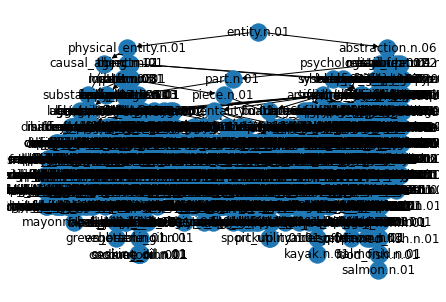

In [16]:
import matplotlib.pyplot as plt
pos = nx.nx_pydot.graphviz_layout(Gprime, prog='dot')
nx.draw(Gprime, pos, with_labels=True, arrows=True)
plt.show()

In [17]:
import plotly.graph_objects as go


ModuleNotFoundError: No module named 'plotly'